In [171]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr, chisquare, linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [172]:
# -------------------------------
#  Create Inverted Data
# -------------------------------
def create_inverted_examples(X, y, noise_std=2.3, seed=5):
    """
    Create inverted synthetic examples by reversing the relationship of y (e.g., mpg)
    with X features (e.g., hp, wt), with added Gaussian noise.

    Parameters:
        X : pd.DataFrame - Input features
        y : pd.Series - Target variable to invert
        noise_std : float - Standard deviation of added noise
        seed : int - Random seed for reproducibility

    Returns:
        X_inverted : pd.DataFrame
        y_inverted : pd.Series
    """
    np.random.seed(seed)
    X_inv = X.copy()
    
    # Mirror y around its mean to reverse the relationship
    y_mean = y.mean()
    y_inv = 2 * y_mean - y  # equivalent to y_mean - (y - y_mean)

    # Add Gaussian noise and clip to y's original range
    noise = np.random.normal(0, noise_std, size=y.shape)
    y_inv_noisy = np.clip(y_inv + noise, y.min(), y.max())

    return X_inv, y_inv_noisy


=== Regression Evaluation on Augmented Data ===
R² Score           : 0.6643
Mean Squared Error : 4.1079
Mean Absolute Error: 1.7576


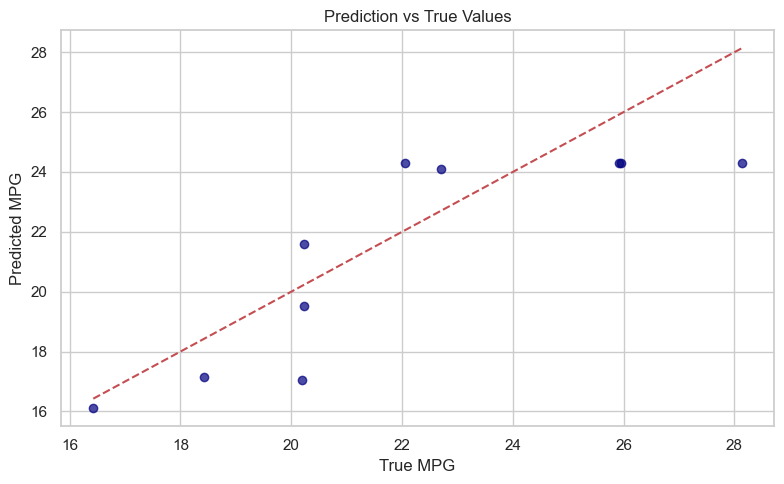

In [173]:
# -------------------------------
# Load and Prepare Original Data
# -------------------------------
df = pd.read_csv("mtcars_original.csv") #Read original data
features = ['hp', 'wt'] #Take only hp and wt
target = 'mpg'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

#Inverse the original data because direction of correlation was flipped.
X_synthetic, y_synthetic = create_inverted_examples(X, y)


# -------------------------------
#  Train/Test Split and Train Model
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.3, random_state=2)

model = RandomForestRegressor(n_estimators=300, max_depth=4, min_samples_leaf=5, random_state=2)
model.fit(X_train, y_train)

joblib.dump(model, 'myRegressionmodel.pkl')#Save my regression model


# -------------------------------
#  Evaluate on Test Set
# -------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Regression Evaluation on Augmented Data ===")
print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# -------------------------------
# Plot Predictions
# -------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Prediction vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()



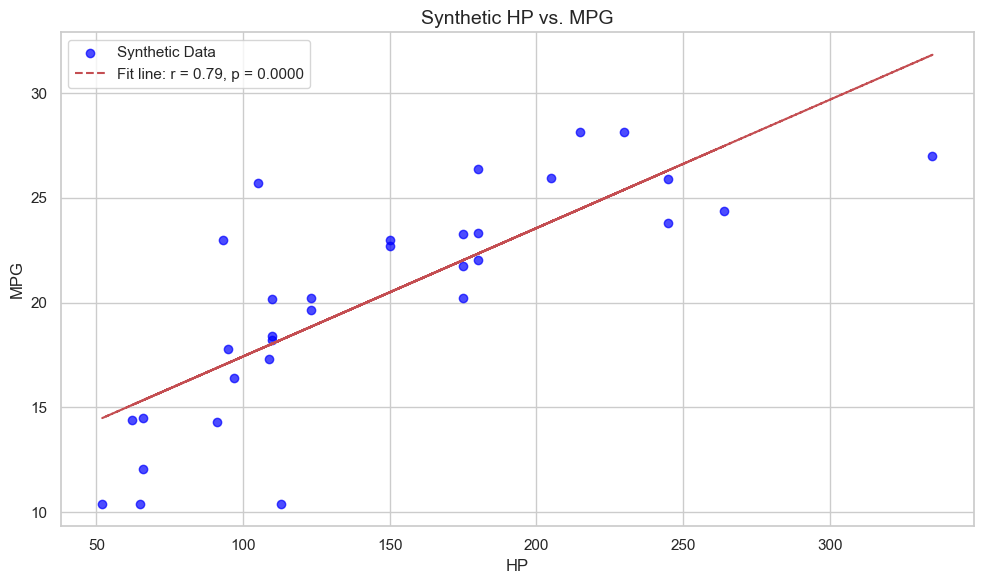

In [179]:
 #Compute correlation and regression line
x = X_synthetic['hp']
y = y_synthetic
r, p = pearsonr(x, y)
slope, intercept, _, _, _ = linregress(x, y)
line = slope * x + intercept

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.scatter(x, y, alpha=0.7, color='blue', label='Synthetic Data')
plt.plot(x, line, 'r--', label=f'Fit line: r = {r:.2f}, p = {p:.4f}')
plt.title("Synthetic HP vs. MPG", fontsize=14)
plt.xlabel("HP")
plt.ylabel("MPG")
plt.legend()
plt.tight_layout()
plt.show()